# Habituation to turbulent backgrounds with ReLU PN activation

Same as the main turbulent_habituation_recognition.ipynb notebook but with ReLU PN  


## Imports

In [1]:
import numpy as np
from scipy import sparse, special
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from time import perf_counter
import os, json
from os.path import join as pj
import sys
if ".." not in sys.path:
    sys.path.insert(1, "..")


from modelfcts.ibcm import (
    integrate_inhib_ibcm_network_options,
    ibcm_respond_new_odors,
    compute_mbars_hgammas_hbargammas,
    ibcm_respond_new_odors
)
from modelfcts.ibcm_analytics import (
    fixedpoint_thirdmoment_exact, 
    ibcm_fixedpoint_w_thirdmoment, 
    ibcm_all_largest_eigenvalues
)
from modelfcts.biopca import (
    integrate_inhib_biopca_network_skip,
    build_lambda_matrix,
    biopca_respond_new_odors
)
from modelfcts.average_sub import (
    integrate_inhib_average_sub_skip, 
    average_sub_respond_new_odors
)
from modelfcts.ideal import (
    find_projector, 
    find_parallel_component, 
    ideal_linear_inhibitor, 
    compute_ideal_factor, 
    relu_inplace
)
from modelfcts.checktools import (
    analyze_pca_learning, 
    check_conc_samples_powerlaw_exp1
)
from modelfcts.backgrounds import (
    update_powerlaw_times_concs, 
    logof10, 
    generate_odorant,
    sample_ss_conc_powerlaw, 
    generate_gamma_odorant
)
from modelfcts.tagging import (
    project_neural_tag, 
    create_sparse_proj_mat, 
    SparseNDArray, 
)
from utils.statistics import seed_from_gen
from modelfcts.distribs import (
    truncexp1_average,
    powerlaw_cutoff_inverse_transform
)
from utils.smoothing_function import (
    moving_average, 
    moving_var
)
from simulfcts.plotting import (
    plot_hbars_gamma_series, 
    plot_w_matrix, 
    plot_background_norm_inhibition, 
    plot_background_neurons_inhibition, 
    plot_pca_results, 
    hist_outline
)
from simulfcts.analysis import compute_back_reduction_stats
from utils.metrics import jaccard, l2_norm

### Aesthetic parameters

In [2]:
do_save_plots = False

root_dir = pj("..")
panels_folder = pj(root_dir, "figures", "correlation")
params_folder = pj(root_dir, "results", "common_params")

# rcParams
with open(pj(params_folder, "olfaction_rcparams.json"), "r") as f:
    new_rcParams = json.load(f)
plt.rcParams.update(new_rcParams)

# color maps
with open(pj(params_folder, "back_colors.json"), "r") as f:
    all_back_colors = json.load(f)
back_color = all_back_colors["back_color"]
back_color_samples = all_back_colors["back_color_samples"]
back_palette = all_back_colors["back_palette"]

with open(pj(params_folder, "model_colors.json"), "r") as f:
    model_colors = json.load(f)
with open(pj(params_folder, "model_nice_names.json"), "r") as f:
    model_nice_names = json.load(f)

models = list(model_colors.keys())
print(models)

['ibcm', 'biopca', 'avgsub', 'optimal', 'ideal', 'orthogonal', 'none']


### Initialization

In [3]:
# Initialize common simulation parameters
n_dimensions = 25  # Half the real number for faster simulations
n_components = 6  # Number of background odors

inhib_rates = [0.00025, 0.0001]  # alpha, beta  [0.00025, 0.00005]

# Simulation duration
duration = 360000.0
deltat = 1.0
n_chunks = 1
skp = 10 * int(1.0 / deltat)

# Common model options
activ_function = "ReLU"  #"identity"

# Background process
update_fct = update_powerlaw_times_concs

# Choose randomly generated background vectors
rgen_meta = np.random.default_rng(seed=0xc0c658deef926d412730bf25bbe83775)
back_components = np.zeros([n_components, n_dimensions])
for i in range(n_components):
    back_components[i] = generate_odorant(n_dimensions, rgen_meta)
    back_components[i] /= l2_norm(back_components[i])

# Seed for background simulation, to make sure all models are the same
simul_seed = seed_from_gen(rgen_meta)

# Turbulent background parameters: same rates and constants for all odors
back_params = [
    np.asarray([1.0] * n_components),        # whiff_tmins
    np.asarray([500.] * n_components),       # whiff_tmaxs
    np.asarray([1.0] * n_components),        # blank_tmins
    np.asarray([800.0] * n_components),      # blank_tmaxs
    np.asarray([0.6] * n_components),        # c0s
    np.asarray([0.5] * n_components),        # alphas
]
back_params.append(back_components)

# Initial values of background process variables (t, c for each variable)
init_concs = sample_ss_conc_powerlaw(*back_params[:-1], size=1, rgen=rgen_meta)
init_times = powerlaw_cutoff_inverse_transform(
                rgen_meta.random(size=n_components), *back_params[2:4])
tc_init = np.stack([init_times, init_concs.squeeze()], axis=1)

# Initial background vector 
init_bkvec = tc_init[:, 1].dot(back_components)
# nus are first in the list of initial background params
init_back_list = [tc_init, init_bkvec]

### Pairwise similarity between background odors
Determines how well-posed the PCA is and how easy it is for the IBCM model to disentangle odors


## IBCM habituation
### IBCM simulation

In [4]:
# IBCM model parameters
n_i_ibcm = 24  # Number of inhibitory neurons for IBCM case

# Model rates
learnrate_ibcm = 0.001  #5e-5
tau_avg_ibcm = 1600  # 2000
coupling_eta_ibcm = 0.6/n_i_ibcm
ssat_ibcm = 50.0
k_c2bar_avg = 0.1
decay_relative_ibcm = 0.005
lambd_ibcm = 1.0
ibcm_rates = [
    learnrate_ibcm, 
    tau_avg_ibcm, 
    coupling_eta_ibcm, 
    lambd_ibcm,
    ssat_ibcm, 
    k_c2bar_avg,
    decay_relative_ibcm 
]
ibcm_options = {
    "activ_fct": activ_function, 
    "saturation": "tanh", 
    "variant": "law", 
    "decay": True
}

# Initial synaptic weights: small positive noise
init_synapses_ibcm = 0.3*rgen_meta.standard_normal(size=[n_i_ibcm, n_dimensions])*lambd_ibcm

In [5]:
def recompute_theta_series(cbser, tau, dt):
    theta = np.zeros([cbser.shape[0], cbser.shape[1]])
    theta[0] = cbser[0]**2
    for i in range(cbser.shape[0]-1):
        theta[i+1] = theta[i] + dt/tau*(cbser[i]*cbser[i] - theta[i])
    return theta

In [6]:
# Run the IBCM simulations
# Perform successive shorter runs/restarts for memory efficiency
tser_ibcm = []
nuser_ibcm = []
bkvecser_ibcm = []
mser_ibcm = []
hbarser_ibcm = []
wser_ibcm = []
yser_ibcm = []
thetaser_ibcm = []
if n_chunks > 1:
    seed_spawns = np.random.SeedSequence(simul_seed).spawn(10)
else:
    seed_spawns = [simul_seed]
for i in range(n_chunks):
    tstart = perf_counter()
    if i == 0:
        init_vari = init_synapses_ibcm
        init_back = init_back_list
    else:
        init_vari = [mser_ibcm[i-1][-1], thetaser_ibcm[i-1][-1], wser_ibcm[i-1][-1]]
        init_back = [nuser_ibcm[i-1][-1], bkvecser_ibcm[i-1][-1]]
    sim_results = integrate_inhib_ibcm_network_options(
                init_vari, update_fct, init_back, 
                ibcm_rates, inhib_rates, back_params, duration/n_chunks, 
                deltat, seed=seed_spawns[i], noisetype="uniform",  
                skp=skp, **ibcm_options
    )
    tser_ibcm.append(sim_results[0] + i/n_chunks*duration)
    nuser_ibcm.append(sim_results[1])
    bkvecser_ibcm.append(sim_results[2])
    mser_ibcm.append(sim_results[3]) 
    hbarser_ibcm.append(sim_results[4]) 
    thetaser_ibcm.append(sim_results[5])
    wser_ibcm.append(sim_results[6])
    yser_ibcm.append(sim_results[7])
    tend = perf_counter()
    print("Finished chunk", i, "in {:.2f} s".format(tend - tstart))

# Concatenate
tser_ibcm = np.concatenate(tser_ibcm, axis=0)
nuser_ibcm = np.concatenate(nuser_ibcm)
bkvecser_ibcm = np.concatenate(bkvecser_ibcm)
mser_ibcm = np.concatenate(mser_ibcm)
hbarser_ibcm = np.concatenate(hbarser_ibcm)
thetaser_ibcm = np.concatenate(thetaser_ibcm)
wser_ibcm = np.concatenate(wser_ibcm)
yser_ibcm = np.concatenate(yser_ibcm)

Finished chunk 0 in 12.06 s


### IBCM habituation analysis

In [7]:
# Calculate hgammas_bar and mbars
transient = int(5/6*duration / deltat) // skp
# Dot products \bar{h}_{\gamma} = \bar{\vec{m}} \cdot \vec{x}_{\gamma}
mbarser, h_gammas, hbars_gamma = compute_mbars_hgammas_hbargammas(
                                    mser_ibcm, coupling_eta_ibcm, back_components)
sums_hbars_gamma = np.sum(hbars_gamma, axis=2)
sums_hbars_gamma2 = np.sum(hbars_gamma*hbars_gamma, axis=2)

# Analytical prediction, exact: need moments of nu. Easiest to compute numerically. 
conc_ser = nuser_ibcm[:, :, 1]
# Odors are all iid so we can average over all odors
mean_conc = np.mean(conc_ser)
sigma2_conc = np.var(conc_ser)
thirdmom_conc = np.mean((conc_ser - mean_conc)**3)
moments_conc = [mean_conc, sigma2_conc, thirdmom_conc]

# Analytical prediction
res = fixedpoint_thirdmoment_exact(moments_conc, 1, n_components-1)
h_specif, h_nonspecif = res[:2]
hs_hn = res[:2]

# Count how many dot products are at each possible value. Use cbar = 1.0 as a split. 
split_val = 2.0
hbars_gamma_mean = np.mean(hbars_gamma[transient:], axis=0)
hgammas_bar_counts = {"above": int(np.sum(hbars_gamma_mean.flatten() > split_val)), 
                      "below": int(np.sum(hbars_gamma_mean.flatten() <= split_val))}
print(hgammas_bar_counts)

specif_gammas = np.argmax(np.mean(hbars_gamma[transient:], axis=0), axis=1)
print(specif_gammas)

# Analytical W
analytical_w = ibcm_fixedpoint_w_thirdmoment(inhib_rates, moments_conc, back_components, hs_hn, specif_gammas)

{'above': 24, 'below': 120}
[0 2 1 3 3 2 5 4 0 2 4 5 5 3 1 2 2 3 1 5 5 3 2 5]


In [8]:
print(moments_conc)

[np.float64(0.17090766902720797), np.float64(0.0984720083194503), np.float64(0.09768745890947236)]


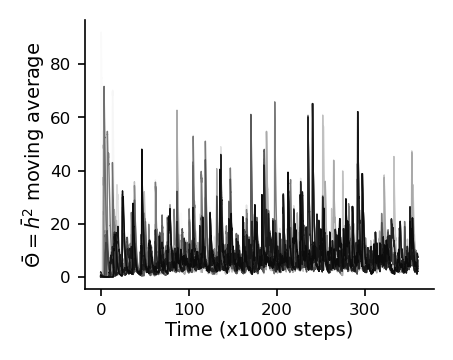

In [9]:
fig, ax = plt.subplots()
#ax.plot(tser_ibcm[:300], nuser_ibcm[:300, :, 1])
neurons_cmap = sns.color_palette("Greys", n_colors=n_i_ibcm)
for i in range(n_i_ibcm):
    ax.plot(tser_ibcm/1000, thetaser_ibcm[:, i], lw=0.5, color=neurons_cmap[i])
ax.set(xlabel="Time (x1000 steps)", ylabel=r"$\bar{\Theta} = \bar{h}^2$ moving average")
plt.show()
plt.close()

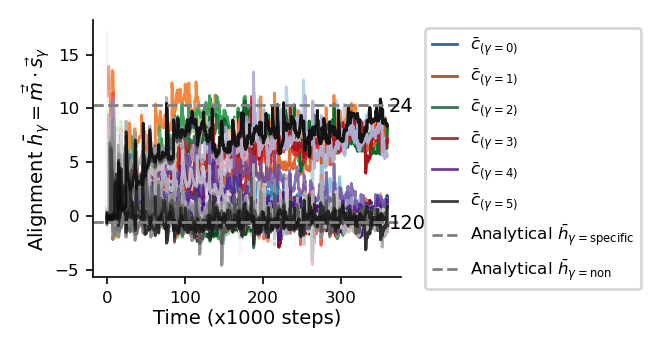

In [10]:
fig , ax, _ = plot_hbars_gamma_series(tser_ibcm, hbars_gamma, 
                        skp=10, transient=320000 // skp)
fig.set_size_inches(plt.rcParams["figure.figsize"][0]*1.5, plt.rcParams["figure.figsize"][1])
# Compare to exact analytical fixed point solution
#ax.set_xlim([350, 360])
ax.axhline(h_specif, ls="--", color="grey", 
           label=r"Analytical $\bar{h}_{\gamma=\mathrm{specific}}$")
ax.axhline(h_nonspecif, ls="--", color="grey", 
           label=r"Analytical $\bar{h}_{\gamma=\mathrm{non}}$")
fig.tight_layout()
leg = ax.legend(loc="upper left", bbox_to_anchor=(1.05, 1.))
fig.tight_layout()
plt.show()
plt.close()

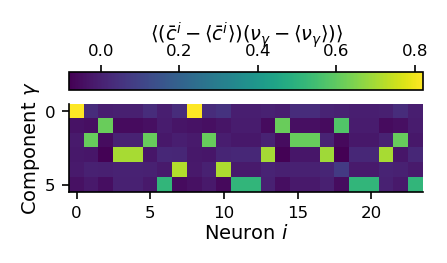

Number of neurons specific to component 0: 2
Number of neurons specific to component 1: 3
Number of neurons specific to component 2: 6
Number of neurons specific to component 3: 5
Number of neurons specific to component 4: 2
Number of neurons specific to component 5: 6


In [11]:
# Correlation between nu's and c's, see if some neurons are specific to odors
# Each neuron turns out to correlate its response to  one concentration
# that means it is specific to that odor. 
hbarser_norm_centered = hbarser_ibcm - np.mean(hbarser_ibcm[transient:], axis=0)
conc_ser_centered = (nuser_ibcm[:, :, 1] 
                     - np.mean(nuser_ibcm[transient:, :, 1], axis=0))
correl_c_nu = np.mean(hbarser_norm_centered[transient:, :, None] 
                      * conc_ser_centered[transient:, None, :], axis=0)

fig, ax = plt.subplots()
img = ax.imshow(correl_c_nu.T)
ax.set(ylabel=r"Component $\gamma$", xlabel=r"Neuron $i$")
fig.colorbar(img, label=r"$\langle (\bar{c}^i - \langle \bar{c}^i \rangle)"
             r"(\nu_{\gamma} - \langle \nu_{\gamma} \rangle) \rangle$", 
            location="top")
fig.tight_layout()
#fig.savefig("figures/correlation/specificities_turbulent_background_ReLU.pdf", 
#           transparent=True, bbox_inches="tight")
plt.show()
plt.close()

# Check if each component has at least one neuron
for comp in range(n_components):
    print("Number of neurons specific to component {}: {}".format(
            comp, np.sum(np.mean(hbars_gamma[-2000:, :, comp], axis=0) > split_val)))

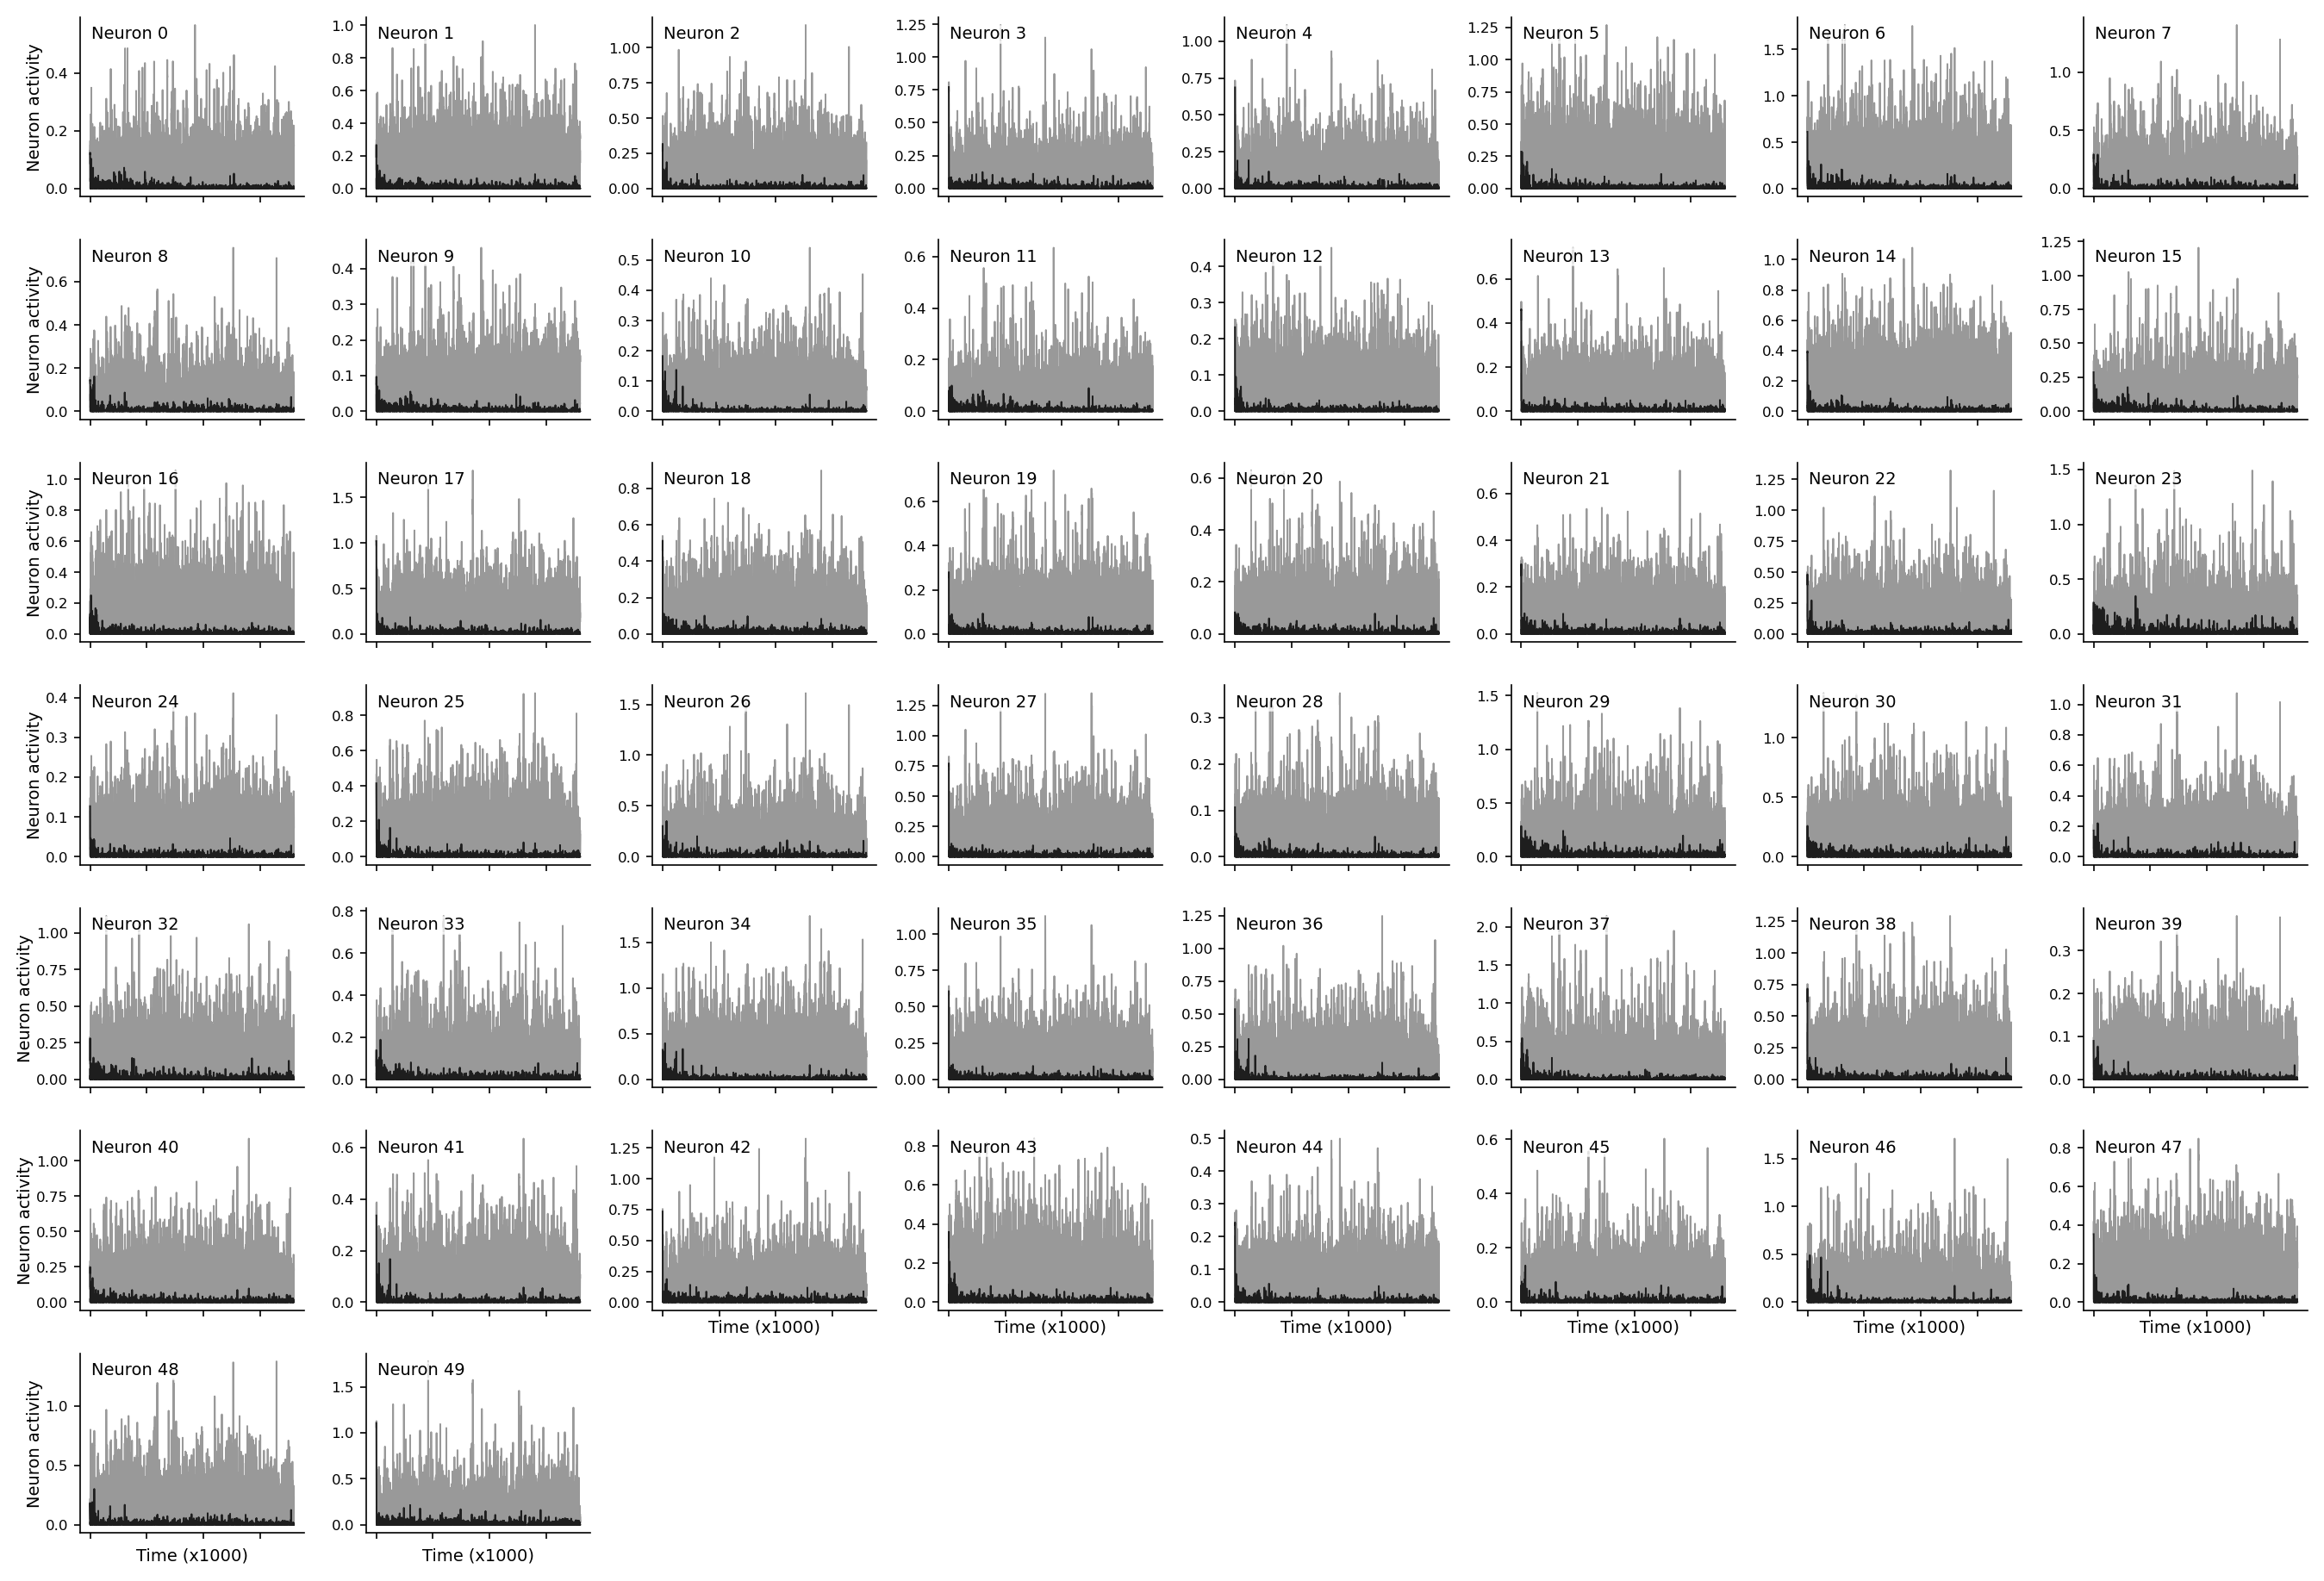

In [12]:
fig, axes, _ = plot_background_neurons_inhibition(tser_ibcm, bkvecser_ibcm, yser_ibcm, skp=1)
plt.show()
plt.close()

Mean activity norm reduced to 2.2 % of input
Standard deviation of activity norm reduced to 3.9 % of input


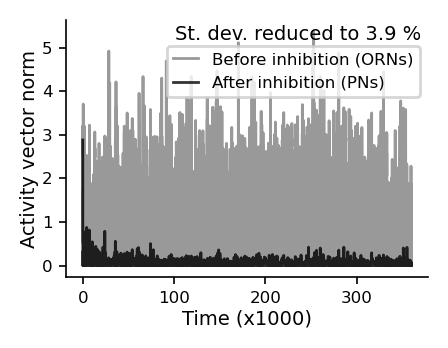

In [13]:
fig, ax, bknorm_ser, ynorm_ser = plot_background_norm_inhibition(
                                tser_ibcm, bkvecser_ibcm, yser_ibcm, skp=1)

# Compute noise reduction factor, annotate
transient = 100000 // skp
norm_stats = compute_back_reduction_stats(bknorm_ser, ynorm_ser, trans=transient)

print("Mean activity norm reduced to "
      + "{:.1f} % of input".format(norm_stats['avg_reduction'] * 100))
print("Standard deviation of activity norm reduced to "
      + "{:.1f} % of input".format(norm_stats['std_reduction'] * 100))
ax.annotate("St. dev. reduced to {:.1f} %".format(norm_stats['std_reduction'] * 100), 
           xy=(0.98, 0.98), xycoords="axes fraction", ha="right", va="top")

ax.legend(loc="center right", bbox_to_anchor=(1.0, 0.8))
fig.tight_layout()
#fig.savefig("figures/correlation/pn_activity_norm_turbulent_background_ReLU.pdf", 
#            transparent=True, bbox_inches="tight")
plt.show()
plt.close()

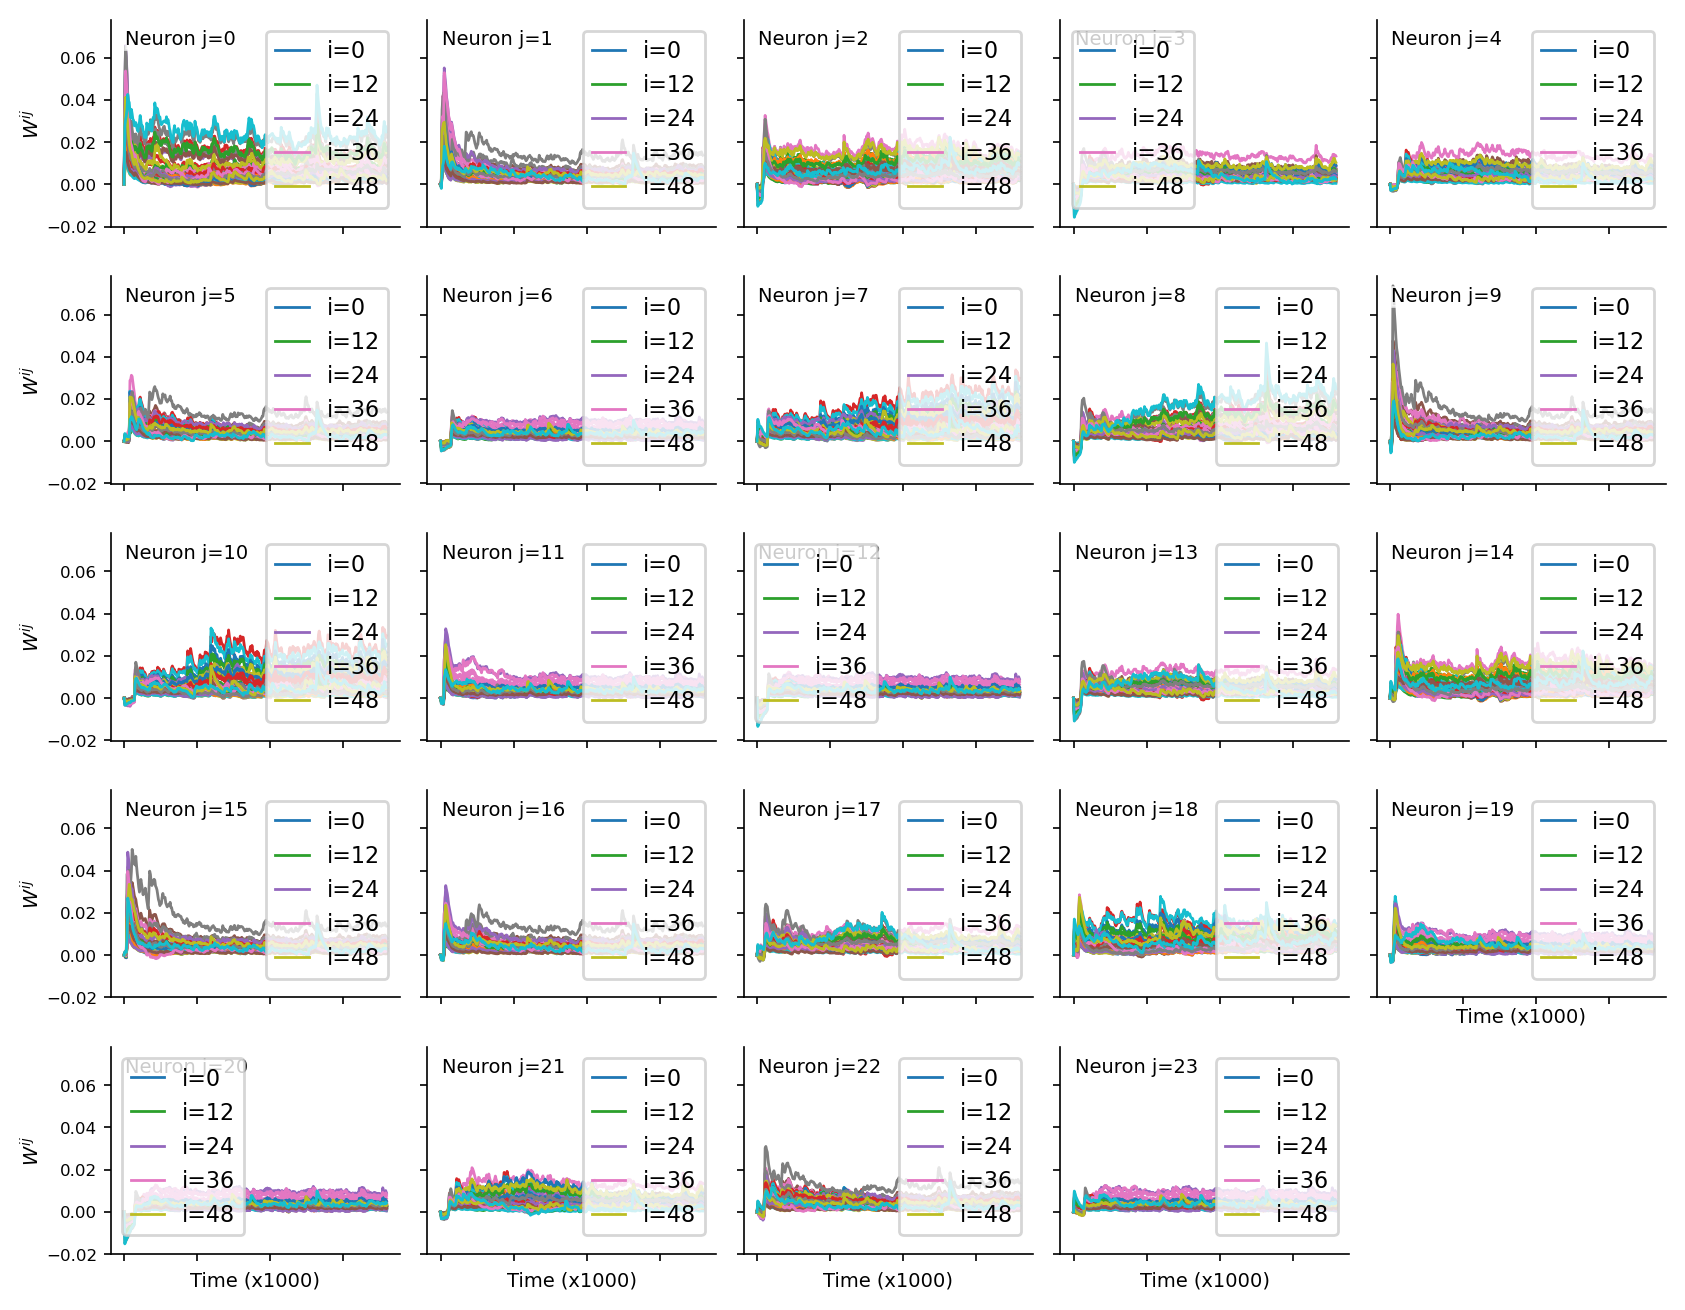

In [14]:
fig, axes = plot_w_matrix(tser_ibcm, wser_ibcm, skp=100)
fig.tight_layout()
#fig.savefig("figures/correlation/w_series_turbulent_background_ReLU.pdf", 
#            transparent=True, bbox_inches="tight")
plt.show()
plt.close()

### Stability of average fixed points
Check the eigenvalues of the jacobian for one neuron, for every possible specificity. There are $2^{n_B}$ possibilities: choosing specific or not for each odor

In [15]:
all_max_eigenvalues = ibcm_all_largest_eigenvalues(
    moments_conc, ibcm_rates, back_components, m3=1.0, cut=1e-16, options=ibcm_options
)

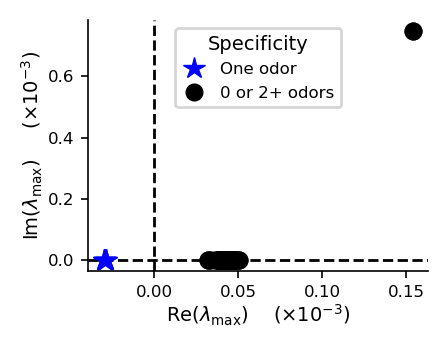

In [16]:
fig, ax = plt.subplots()
ibcm_specif_keys = list(all_max_eigenvalues.keys())
ibcm_eig_values = np.asarray([all_max_eigenvalues[a] for a in ibcm_specif_keys])
reals, imags = np.real(ibcm_eig_values), np.imag(ibcm_eig_values)
ibcm_eig_values_specif1 = np.asarray([len(s) == 1 for s in ibcm_specif_keys], dtype=bool)
highlights = ibcm_eig_values_specif1
ax.axvline(0.0, ls="--", color="k", lw=1.0)
ax.axhline(0.0, ls="--", color="k", lw=1.0)
scaleup = 1e3
ax.plot(reals[highlights]*scaleup, imags[highlights]*scaleup, marker="*", mfc="b", mec="b", 
        ls="none", label="One odor", ms=8)
ax.plot(reals[~highlights]*scaleup, imags[~highlights]*scaleup, marker="o", mfc="k", mec="k", 
       ls="none", label="0 or 2+ odors", ms=6)
for side in ("top", "right"):
    ax.spines[side].set_visible(False)
ax.legend(title="Specificity")
ax.set(xlabel=r"$\mathrm{Re}(\lambda_{\mathrm{max}})$    ($\times 10^{-3}$)", 
      ylabel=r"$\mathrm{Im}(\lambda_{\mathrm{max}})$     ($\times 10^{-3}$)")
fig.tight_layout()
plt.show()
plt.close()

## BioPCA simulation
### BioPCA habituation simulation

In [17]:
# BioPCA model parameters
n_i_pca = n_components  # Number of inhibitory neurons for BioPCA case

# Model rates
learnrate_pca = 1e-4  # Learning rate of M
# Choose Lambda diagonal matrix as advised in Minden et al., 2018
# but scale it up to counteract W regularization
lambda_range_pca = 0.5
lambda_max_pca = 8.0
# Learning rate of L, relative to learnrate. Adjusted to Lambda in the integration function
rel_lrate_pca = 2.0  #  / lambda_max_pca**2 
lambda_mat_diag = build_lambda_matrix(lambda_max_pca, lambda_range_pca, n_i_pca)

xavg_rate_pca = learnrate_pca
pca_options = {
    "activ_fct": activ_function, 
    "remove_lambda": False, 
    "remove_mean": True
}
biopca_rates = [learnrate_pca, rel_lrate_pca, lambda_max_pca, lambda_range_pca, xavg_rate_pca]


# Initial synaptic weights: small positive noise
# We selected a seed (out of 40+ tested) giving initial conditions leading to correct PCA
# The model has trouble converging on this background, we're giving as many chances as possible here. 
rgen_pca = np.random.default_rng(seed=0x8b6664612cfeda4a121436fcfbbca449)
init_synapses_pca = rgen_pca.standard_normal(size=[n_i_pca, n_dimensions]) / np.sqrt(n_i_pca)
init_mmat_pca = rgen_pca.standard_normal(size=[n_i_pca, n_dimensions]) / np.sqrt(n_dimensions)
init_lmat_pca = np.eye(n_i_pca, n_i_pca)  # Supposed to be near-identity, start as identity
ml_inits_pca = [init_mmat_pca, init_lmat_pca]

In [18]:
# Run simulation
sim_results = integrate_inhib_biopca_network_skip(
                ml_inits_pca, update_fct, init_back_list, biopca_rates, 
                inhib_rates, back_params, duration, deltat, 
                seed=simul_seed, noisetype="uniform", skp=skp, **pca_options)
(tser_pca, 
 nuser_pca, 
 bkvecser_pca, 
 mser_pca, 
 lser_pca, 
 xser_pca, 
 hbarser_pca, 
 wser_pca, 
 yser_pca) = sim_results

### BioPCA simulation analysis

In [19]:
res = analyze_pca_learning(bkvecser_pca, mser_pca, lser_pca, 
                           lambda_mat_diag, demean=pca_options["remove_mean"])
true_pca, learnt_pca, fser, off_diag_l_avg_abs, align_error_ser = res

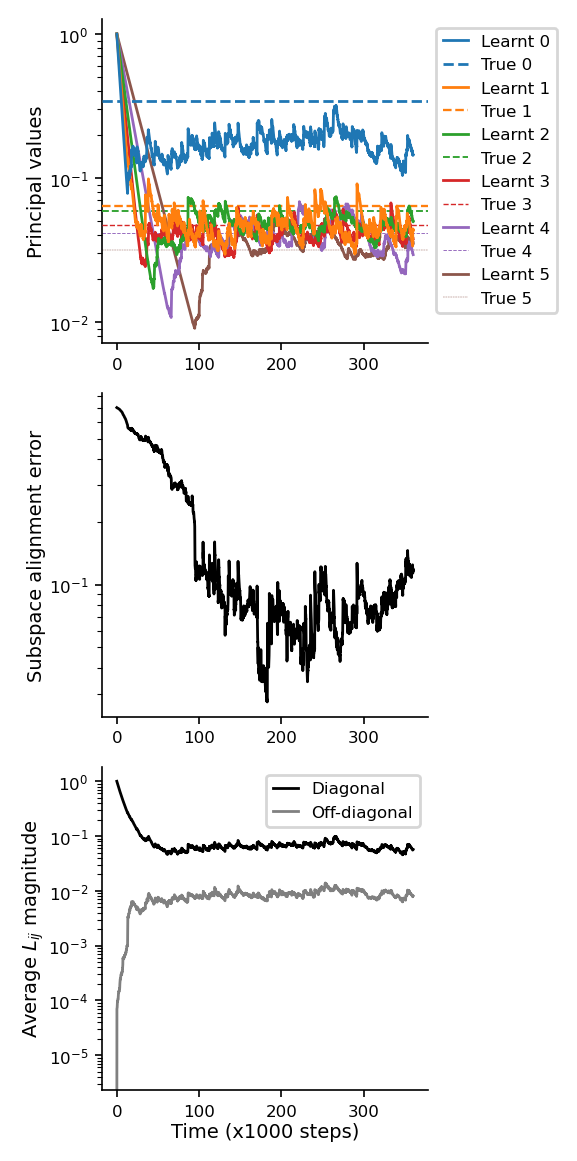

In [20]:
fig, axes = plot_pca_results(tser_pca/1000, true_pca, learnt_pca, align_error_ser, off_diag_l_avg_abs)
axes[-1].set_xlabel("Time (x1000 steps)")
fig.set_size_inches(fig.get_size_inches()[0], fig.get_size_inches()[1]*2.5)
fig.tight_layout()
axes[0].legend(loc="upper left", bbox_to_anchor=(1.0, 1.0))
plt.show()
plt.close()

Mean activity norm reduced to 14.4 % of input
Standard deviation of activity norm reduced to 12.3 % of input


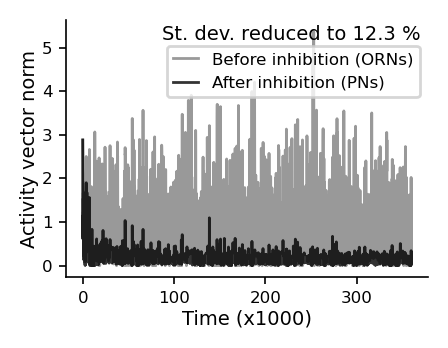

In [21]:
fig, ax, bknorm_ser, ynorm_ser = plot_background_norm_inhibition(
                                tser_pca, bkvecser_pca, yser_pca, skp=10)

# Compute noise reduction factor, annotate
transient = 100000 // skp
norm_stats = compute_back_reduction_stats(bknorm_ser, ynorm_ser, trans=transient)

print("Mean activity norm reduced to "
      + "{:.1f} % of input".format(norm_stats['avg_reduction'] * 100))
print("Standard deviation of activity norm reduced to "
      + "{:.1f} % of input".format(norm_stats['std_reduction'] * 100))
ax.annotate("St. dev. reduced to {:.1f} %".format(norm_stats['std_reduction'] * 100), 
           xy=(0.98, 0.98), xycoords="axes fraction", ha="right", va="top")

ax.legend(loc="center right", bbox_to_anchor=(1.0, 0.8))
fig.tight_layout()
plt.show()
plt.close()

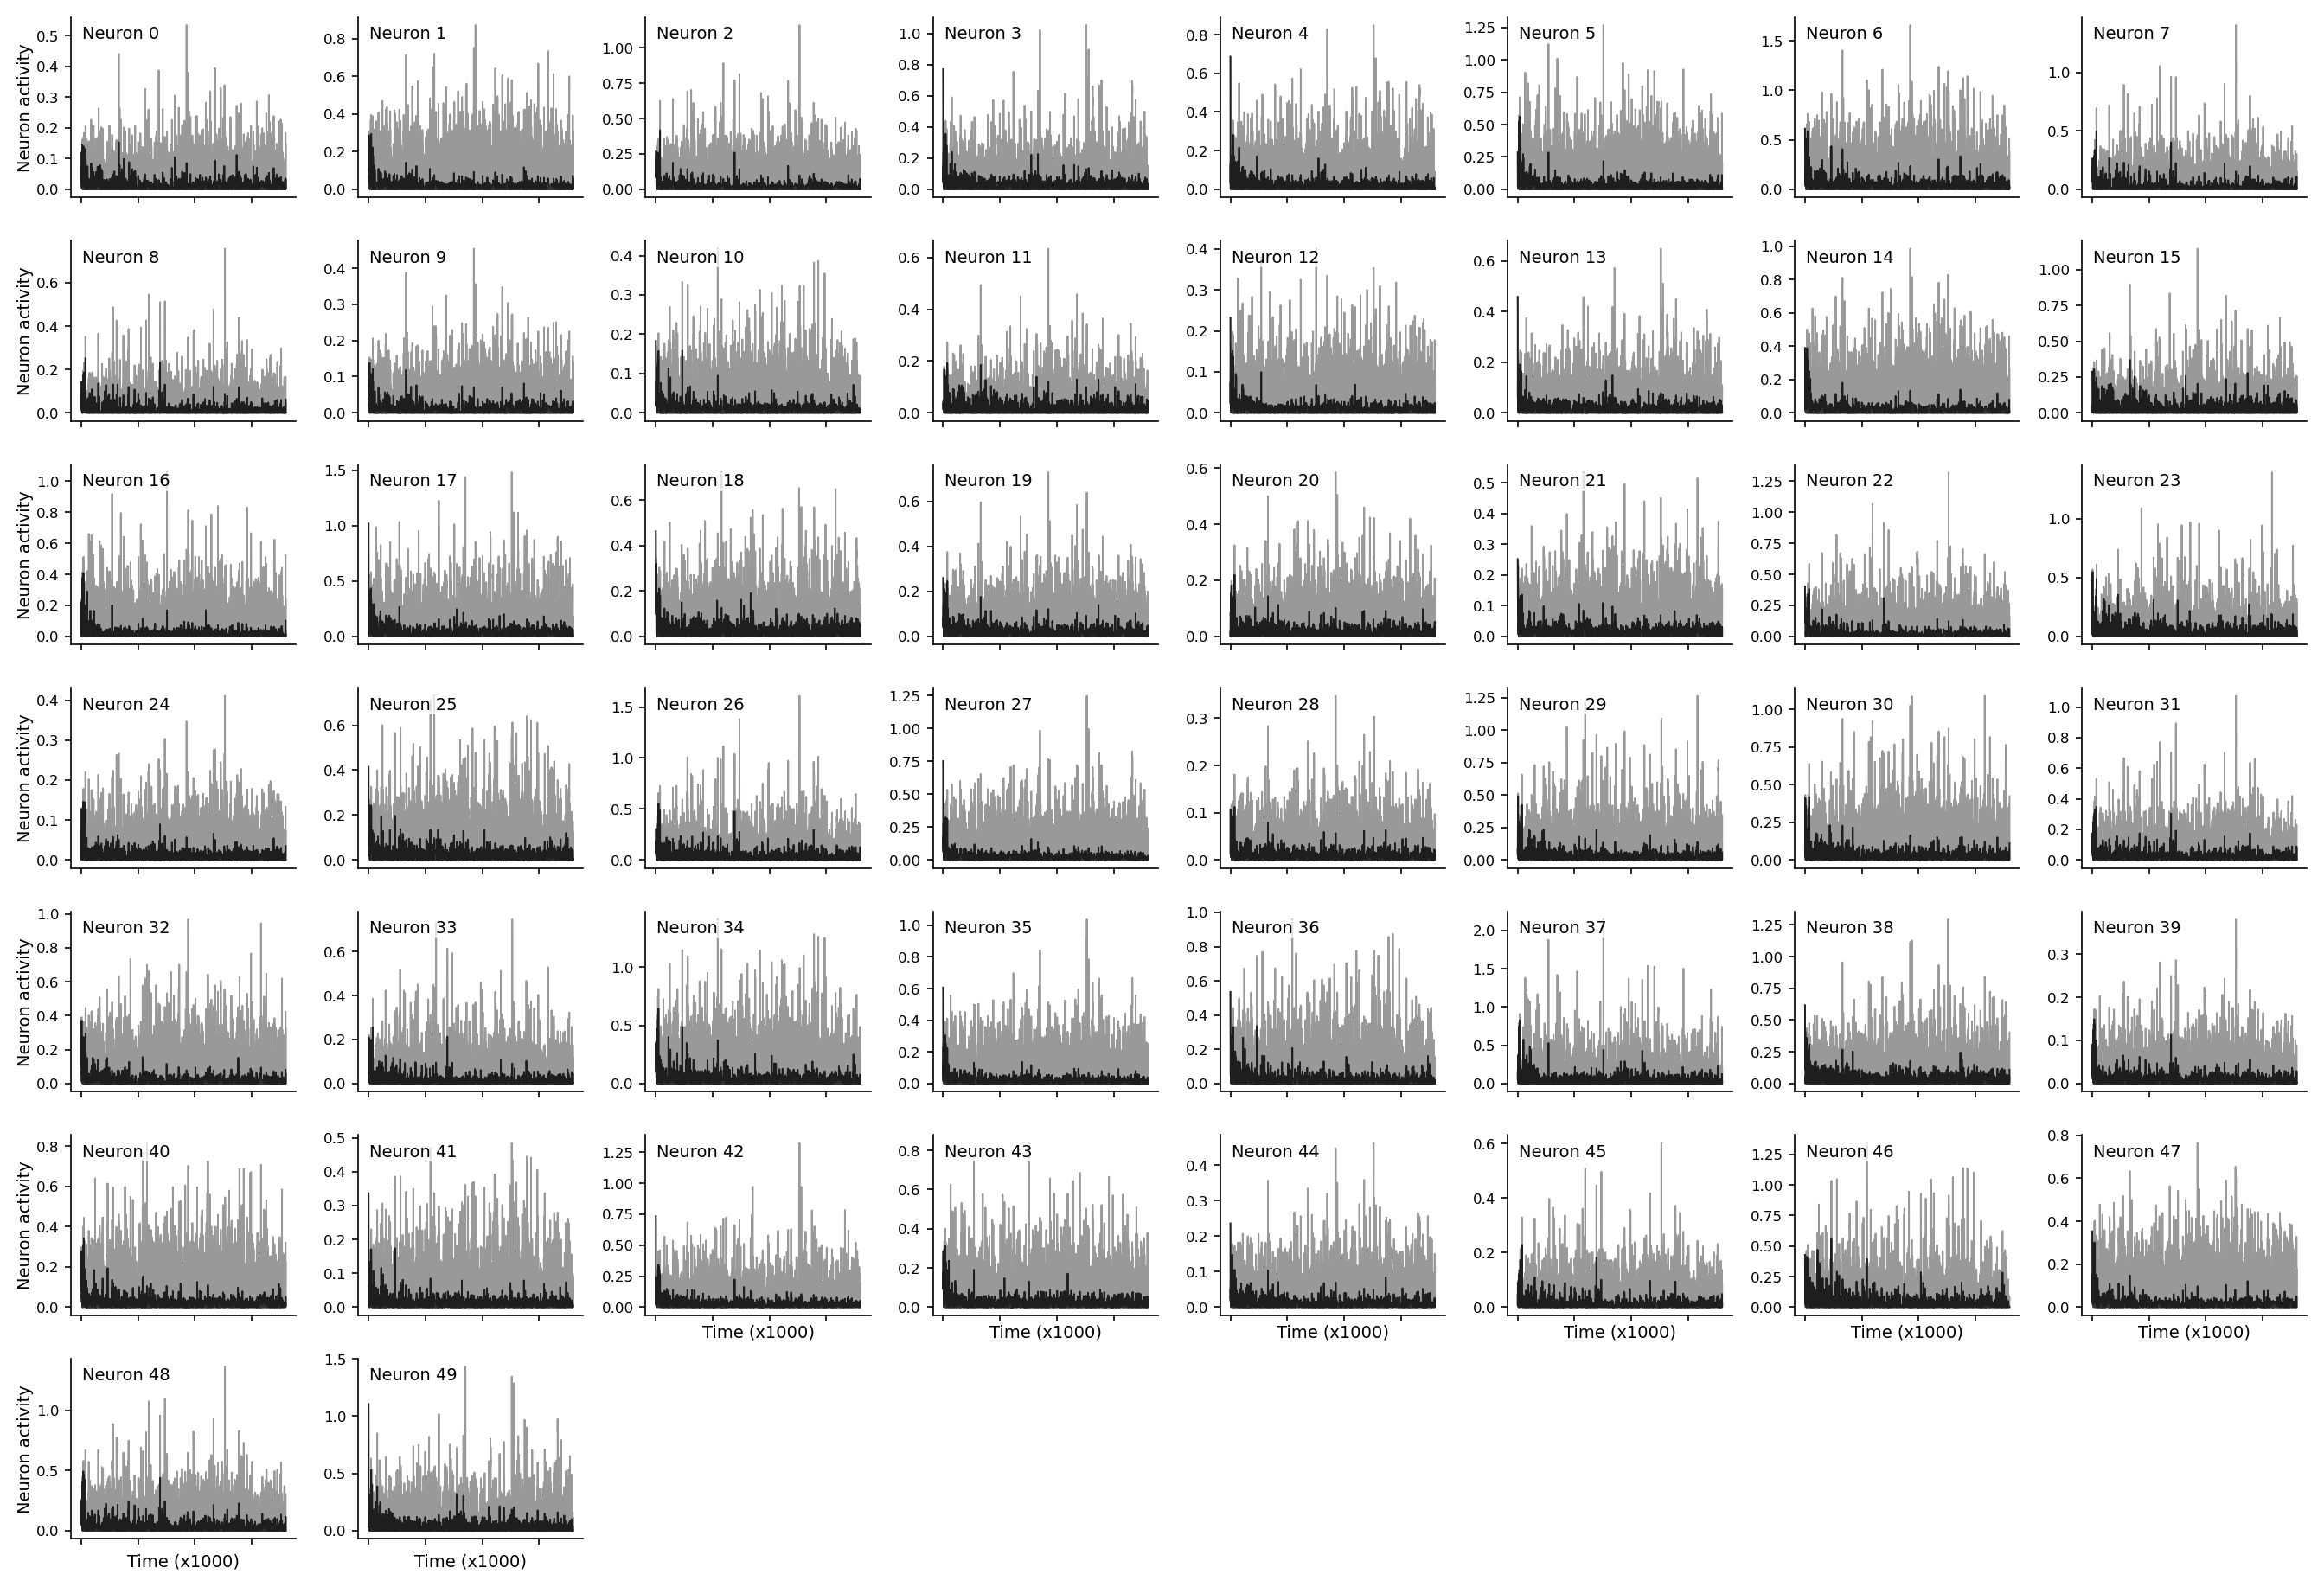

In [22]:
fig, axes, _ = plot_background_neurons_inhibition(tser_pca, bkvecser_pca, yser_pca, skp=10)
plt.show()
plt.close()

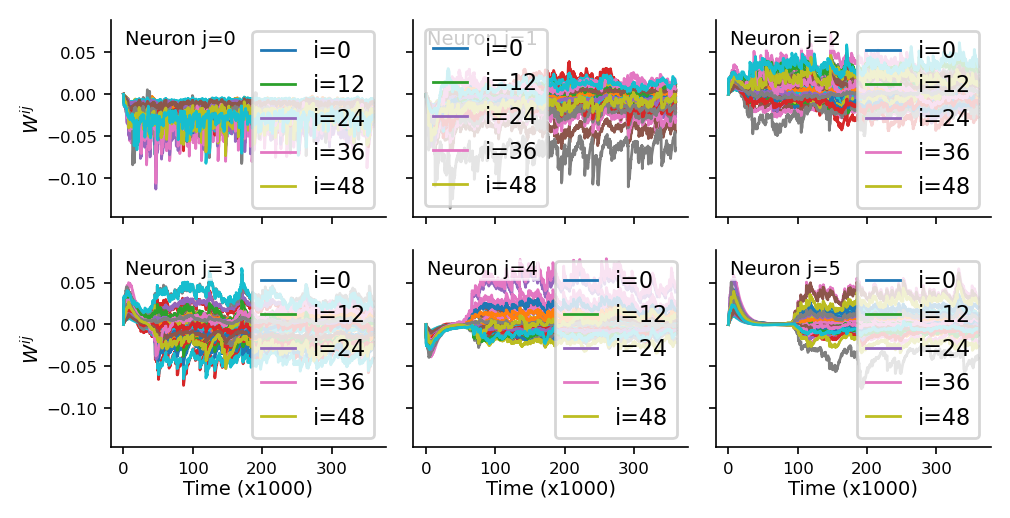

In [23]:
fig, axes = plot_w_matrix(tser_pca, wser_pca, skp=10)
plt.show()
plt.close()

### Average background subtraction simulation

In [24]:
# Average subtraction model parameters
avg_options = {"activ_fct": activ_function}

# Initial synaptic weights: dummy
init_synapses_avg = np.zeros([1, n_dimensions])

In [25]:
sim_results = integrate_inhib_average_sub_skip(
                init_synapses_avg, update_fct, init_back_list, 
                [], inhib_rates, back_params, duration, deltat,
                seed=simul_seed, noisetype="uniform", skp=skp, **avg_options
)
tser_avg, bkser_avg, bkvecser_avg, wser_avg, yser_avg = sim_results

### Ideal inhibition
The component parallel to the background is reduced to beta / (2*alpha + beta). 

In [26]:
back_projector = find_projector(back_components.T)
ideal_factor = inhib_rates[1] / (2*inhib_rates[0] + inhib_rates[1])
yser_ideal = bkvecser_ibcm * ideal_factor

### Orthogonal model

In [27]:
yser_orthogonal = np.zeros(bkvecser_ibcm.shape)

### Optimal model

In [28]:
from modelfcts.ideal import compute_optimal_matrices

In [29]:
# New odor concentrations
new_test_concs = np.asarray([0.5, 1.0])
avg_whiff_conc = np.mean(truncexp1_average(*back_params[4:6]))
print("Average whiff concentration: {:.4f}".format(avg_whiff_conc))
new_test_concs *= avg_whiff_conc
n_new_concs = len(new_test_concs)

Average whiff concentration: 0.3900


In [30]:
# Compute optimal W matrix for all new odors possible
dummy_rgen = np.random.default_rng(0x115959f92ef489f1fe6b034c2ebfcb37)
n_samp = int(1e4)
new_odors_from_distrib = generate_odorant([n_samp, n_dimensions], dummy_rgen)
new_odors_from_distrib = new_odors_from_distrib / l2_norm(new_odors_from_distrib, axis=1)[:, None]
optimal_ws = compute_optimal_matrices(back_components, 
                new_odors_from_distrib, moments_conc, new_test_concs)

yser_optimal = bkvecser_ibcm - bkvecser_ibcm.dot(optimal_ws[0].T)

## Model comparison for background inhibition

In [31]:
ynorm_series = {
    "ibcm": l2_norm(yser_ibcm), 
    "biopca": l2_norm(yser_pca), 
    "avgsub": l2_norm(yser_avg), 
    "none": l2_norm(bkvecser_ibcm), 
    "ideal": l2_norm(yser_ideal), 
    "optimal": l2_norm(yser_optimal)
}
std_options = dict(kernelsize=2001, boundary="free")
mean_options = dict(kernelsize=2001, boundary="free")
std_series = {
    a: np.sqrt(moving_var(ynorm_series[a], **std_options)) for a in ynorm_series
} 
mean_series = {
    a: moving_average(ynorm_series[a], **mean_options) for a in ynorm_series
}

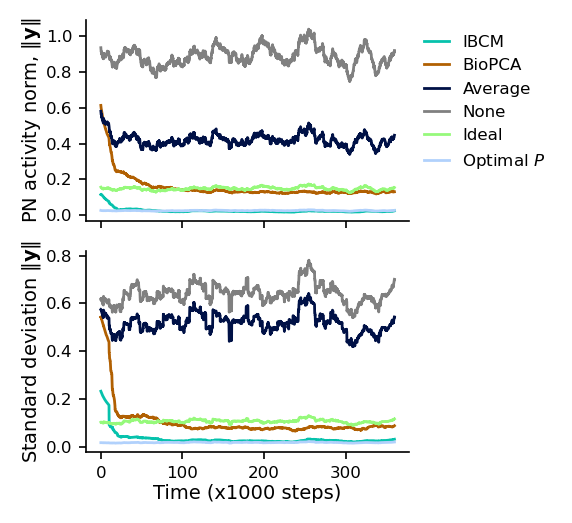

In [32]:
fig, axes = plt.subplots(2, 1, sharex=True)
axes = axes.flatten()
for model in std_series.keys():
    props = dict(label=model_nice_names[model], color=model_colors[model])
    axes[0].plot(tser_ibcm / 1000, mean_series[model], **props)
    axes[1].plot(tser_ibcm / 1000, std_series[model], **props)
ynorm_string = r"$\|\mathbf{y}\|$"
axes[0].set_ylabel(r"PN activity norm, " + ynorm_string)
axes[1].set(xlabel="Time (x1000 steps)", ylabel=r"Standard deviation " + ynorm_string)
axes[0].legend(loc="upper left", bbox_to_anchor=(1.0, 1.0), frameon=False)
fig.set_size_inches(plt.rcParams["figure.figsize"][0]*1.3, 1.5*plt.rcParams["figure.figsize"][1])
fig.tight_layout()
plt.show()
plt.close()

## Model comparison for new odor recognition

In [33]:
# Common parameters
n_kc = 1000 * n_dimensions // 25
projection_arguments = {
    "kc_sparsity": 0.05,
    "adapt_kc": True,
    "n_pn_per_kc": 3 * n_dimensions // 25,
    "project_thresh_fact": 0.1
}
proj_mat = create_sparse_proj_mat(n_kc, n_dimensions, rgen_meta)

In [34]:
# Computing background tag lengths at various time points for each model
yser_dict = {
    "ibcm": yser_ibcm, 
    "biopca": yser_pca, 
    "avgsub": yser_avg, 
    "none": bkvecser_ibcm, 
    "ideal": yser_ideal, 
    "optimal": yser_optimal,
    "orthogonal": yser_orthogonal
}

In [35]:
def find_snap_index(dt, skip, times):
    """ Find nearest multiple of dt*skip to each time in times """
    return np.around(times / (dt*skip)).astype(int)

In [36]:
# Generate new odors, select test times, etc.
# New odors tested
n_new = 100
new_odors = generate_odorant([n_new, n_dimensions], rgen_meta)
new_odors = new_odors / l2_norm(new_odors, axis=1)[:, None]

# Test times
n_test_times = 10
start_test_t = duration - n_test_times * 2000.0
test_times = np.linspace(start_test_t, duration, n_test_times)
test_times -= deltat*skp
test_idx = find_snap_index(deltat, skp, test_times)

# New odor concentrations
new_test_concs = np.asarray([0.5, 1.0])
avg_whiff_conc = np.mean(truncexp1_average(*back_params[4:6]))
print("Average whiff concentration: {:.4f}".format(avg_whiff_conc))
new_test_concs *= avg_whiff_conc
n_new_concs = len(new_test_concs)

# Background samples, indexed [time, sample, n_orn]
n_back_samples = 10
conc_samples = sample_ss_conc_powerlaw(
                    *back_params[:6], size=n_test_times*(n_back_samples-1), rgen=rgen_meta
                )  # Shaped [sample, component]
back_samples = conc_samples.dot(back_components)
back_samples = back_samples.reshape([n_test_times, n_back_samples-1, -1])
back_samples = np.concatenate([bkvecser_ibcm[test_idx, None, :], back_samples], axis=1)

# Containers for s vectors of each model
mixture_yvecs = {a: np.zeros([n_new, n_test_times,  n_new_concs,  
                    n_back_samples, n_dimensions]) for a in yser_dict.keys()}
mixture_tags = {a: SparseNDArray((n_new, n_test_times, n_new_concs,
                    n_back_samples, n_kc), dtype=bool) for a in yser_dict.keys()}
new_odor_tags = sparse.lil_array((n_new, n_kc), dtype=bool)
jaccard_scores = {a: np.zeros([n_new, n_test_times, n_new_concs,  n_back_samples]) 
                  for a in yser_dict.keys()}
jaccard_scores_with_back = {a: np.zeros([n_new, n_test_times, n_new_concs,  n_back_samples, n_components]) 
                  for a in yser_dict.keys()}

Average whiff concentration: 0.3900


In [37]:
# Compute ideal reduction factor for each concentration
dummy_rgen = np.random.default_rng(0x6e3e2886c30163741daaaf7c8b8a00e6)
ideal_factors = [compute_ideal_factor(c, moments_conc[:2], [n_components, n_dimensions], 
                    generate_odorant, (dummy_rgen,)) for c in new_test_concs]

# Compute background odor tags
back_tags = []
for i in range(n_components):
    back_tags.append(project_neural_tag(back_components[i], 
            back_components[i], proj_mat, **projection_arguments
    ))

for i in range(n_new):
    # Compute neural tag of the new odor alone, without inhibition
    new_tag = project_neural_tag(
                    new_odors[i], new_odors[i],
                    proj_mat, **projection_arguments
                )
    new_odor_tags[i, list(new_tag)] = True
    # Parallel and orthogonal components
    x_new_par = find_parallel_component(new_odors[i], 
                        back_components, back_projector)
    x_new_ort = new_odors[i] - x_new_par
    # Now, loop over snapshots, mix the new odor with the back samples,
    # compute the PN response at each test concentration,
    # compute tags too, and save results
    for j in range(n_test_times):
        jj = test_idx[j]
        for k in range(n_new_concs):
            mixtures = (back_samples[j]
                + new_test_concs[k] * new_odors[i])
            # odors, mlx, wmat, 
            # Compute for each model
            mixture_yvecs["ibcm"][i, j, k] = ibcm_respond_new_odors(
                mixtures, mser_ibcm[jj], wser_ibcm[jj], 
                ibcm_rates, options=ibcm_options
            )
            mixture_yvecs["biopca"][i, j, k] = biopca_respond_new_odors(
                mixtures, [mser_pca[jj], lser_pca[jj], xser_pca[jj]], 
                wser_pca[jj], biopca_rates, options=pca_options
            )
            mixture_yvecs["avgsub"][i, j, k] = average_sub_respond_new_odors(
                mixtures, wser_avg[jj], options=avg_options
            )
            mixture_yvecs["none"][i, j, k] = mixtures
            mixture_yvecs["none"][i, j, k] = relu_inplace(mixture_yvecs["none"][i, j, k])
            mixture_yvecs["ideal"][i, j, k] = ideal_linear_inhibitor(
                x_new_par, x_new_ort, back_samples[j], new_test_concs[k], 
                ideal_factors[k], **avg_options
            )
            mixture_yvecs["ideal"][i, j, k] = relu_inplace(mixture_yvecs["ideal"][i, j, k])
            mixture_yvecs["orthogonal"][i, j, k] = x_new_ort
            mixture_yvecs["orthogonal"][i, j, k] = relu_inplace(mixture_yvecs["orthogonal"][i, j, k])
            mixture_yvecs["optimal"][i, j, k] = mixtures - mixtures.dot(optimal_ws[k].T)
            mixture_yvecs["optimal"][i, j, k] = relu_inplace(mixture_yvecs["optimal"][i, j, k])
            for l in range(n_back_samples):
                for mod in mixture_yvecs.keys():
                    mix_tag = project_neural_tag(
                        mixture_yvecs[mod][i, j, k, l], mixtures[l],
                        proj_mat, **projection_arguments
                    )
                    try:
                        mixture_tags[mod][i, j, k, l, list(mix_tag)] = True
                    except ValueError as e:
                        print(mix_tag)
                        print(mixture_yvecs[mod][i, j, k, l])
                        print(proj_mat.dot(mixture_yvecs[mod][i, j, k, l]))
                        raise e
                    jaccard_scores[mod][i, j, k, l] = jaccard(mix_tag, new_tag)
                    # For comparison, compute similarity to each background odor
                    for m in range(n_components):
                        jaccard_scores_with_back[mod][i, j, k, l, m] = jaccard(mix_tag, back_tags[m])

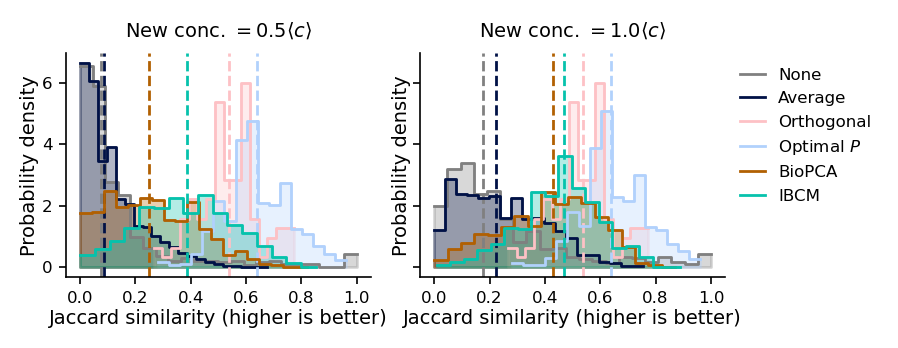

In [38]:
# Plot model histogram results
# One plot per new odor concentration
fig, axes = plt.subplots(1, n_new_concs, sharex=True, sharey=True)
fig.set_size_inches(plt.rcParams["figure.figsize"][0]*2.0, 
                    1.0*plt.rcParams["figure.figsize"][1])
axes = axes.flatten()
models = ["none", "avgsub", "orthogonal", "optimal", "biopca", "ibcm"]
for m in models:  # Plot IBCM last
    all_jacs = jaccard_scores[m]
    for i in range(n_new_concs):
        hist_outline(
            axes[i], all_jacs[:, :, i, :].flatten(),
            bins="doane", density=True, label=model_nice_names.get(m, m),
            color=model_colors.get(m), alpha=1.0
        )
        axes[i].axvline(
            np.median(all_jacs[:, :, i, :]), ls="--",
            color=model_colors.get(m)
        )
# Labeling the graphs, etc.
relative_concs = [c/new_test_concs[1] for c in new_test_concs]
for i in range(n_new_concs):
    ax = axes[i]
    axes[i].set_title(r"New conc. $= {:.1f} \langle c \rangle$".format(relative_concs[i]))
    axes[i].set_xlabel("Jaccard similarity (higher is better)")
    axes[i].set_ylabel("Probability density")
axes[1].legend(loc="upper left", bbox_to_anchor=(1.0, 1.0), frameon=False)
fig.tight_layout()
if do_save_plots:
    fig.savefig(pj(panels_folder, "recognition_performance_onerun_ReLU.pdf"),
            transparent=True, bbox_inches="tight")

plt.show()
plt.close()

In [39]:
# Scatter plot vs distance between new odor and background
 # n_runs, n_test_times, n_back_samples, n_new_odors, n_new_concs, skp
new_back_distances = np.zeros(n_new)
new_back_distances_scaled = np.zeros(n_new)
back_proj = find_projector(back_components.T)
for j in range(n_new):
    new_par = find_parallel_component(new_odors[j], back_components, back_proj)
    new_ort = new_odors[j] - new_par
    new_back_distances[j] = l2_norm(new_ort)
    # Scale relative to the new odor norm
    new_back_distances_scaled[j] = new_back_distances[j] / l2_norm(new_odors[j])
print(np.mean(new_back_distances_scaled))

0.7031713039223003


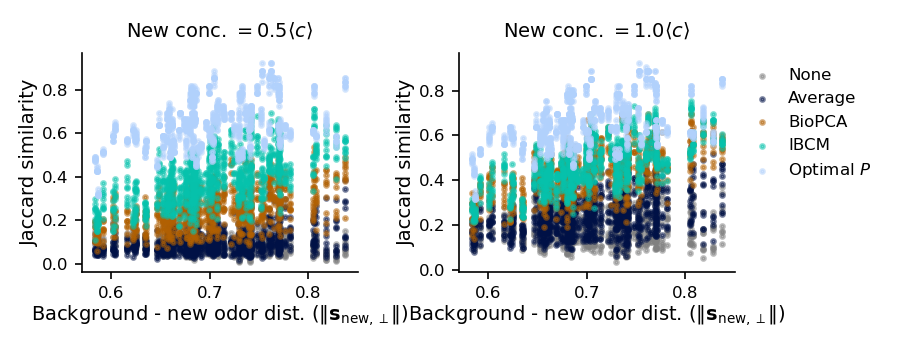

In [40]:
fig, axes = plt.subplots(1, n_new_concs, sharex=True)
fig.set_size_inches(plt.rcParams["figure.figsize"][0]*2.0, 
                    1.0*plt.rcParams["figure.figsize"][1])
axes = axes.flatten()
models = ["none",  "avgsub", "biopca", "ibcm", "optimal"]
for m in models:
    all_jacs = np.median(jaccard_scores[m], axis=(1,))  # Median time point, all back samples there
    all_distances = np.tile(new_back_distances_scaled, (all_jacs.shape[2], 1)).T
    for i in range(n_new_concs):
        axes[i].scatter(all_distances.flatten(), all_jacs[:, i].flatten(), 
            s=2.0, color=model_colors.get(m), alpha=0.5, label=model_nice_names[m])
# Labeling the graphs, etc.
relative_concs = [c/new_test_concs[1] for c in new_test_concs]
for i in range(n_new_concs):
    ax = axes[i]
    axes[i].set_title(r"New conc. $= {:.1f} \langle c \rangle$".format(relative_concs[i]))
    axes[i].set_xlabel(r"Background - new odor dist. ($\| \mathbf{s}_{\mathrm{new}, \perp} \|$)")
    axes[i].set_ylabel("Jaccard similarity")
axes[1].legend(loc="upper left", bbox_to_anchor=(1.0, 1.0), frameon=False)
fig.tight_layout()

#if do_save_plots:
#    fig.savefig("figures/correlation/recognition_vs_distance_back_onerun_ReLU.pdf",
#            transparent=True, bbox_inches="tight")

plt.show()
plt.close()

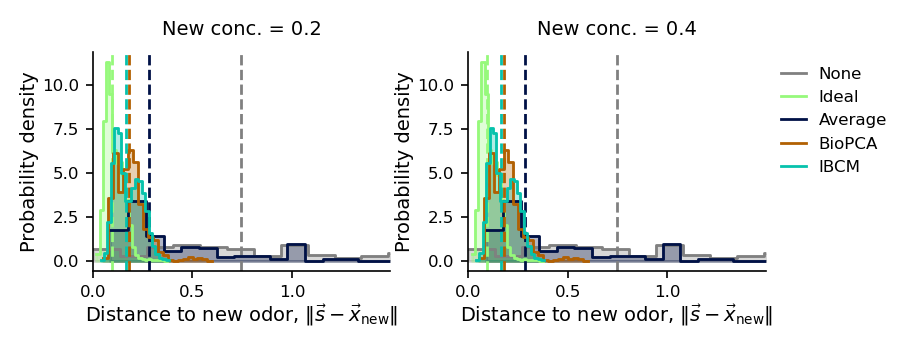

In [41]:
# Distance to new odor
# Plot model histogram results
# One plot per new odor concentration
fig, axes = plt.subplots(1, n_new_concs, sharex=True)
fig.set_size_inches(plt.rcParams["figure.figsize"][0]*2.0, 
                    1.0*plt.rcParams["figure.figsize"][1])
axes = axes.flatten()
models = ["none", "ideal", "avgsub", "biopca", "ibcm"]
all_medians = []
for m in models:  # Plot IBCM last
    all_distances = (mixture_yvecs[m] 
         - new_test_concs[None, None, :, None, None]*new_odors[:, None, None, None, :])
    all_norms = l2_norm(all_distances.reshape(-1, n_dimensions))
    all_medians.append(np.median(all_norms))
    for i in range(n_new_concs):
        hist_outline(
            axes[i], all_norms,
            bins="doane", density=True, label=model_nice_names.get(m, m),
            color=model_colors.get(m), alpha=1.0
        )
        axes[i].axvline(
            all_medians[-1], ls="--",
            color=model_colors.get(m)
        )
# Labeling the graphs, etc.
for i in range(n_new_concs):
    axes[i].set_xlim([0.0, 2.0*max(all_medians)])
    axes[i].set_title("New conc. = {:.1f}".format(new_test_concs[i]))
    axes[i].set_xlabel(r"Distance to new odor, $\|\vec{s} - \vec{x}_{\mathrm{new}}\|$")
    axes[i].set_ylabel("Probability density")
axes[1].legend(loc="upper left", bbox_to_anchor=(1.0, 1.0), frameon=False)
fig.tight_layout()

plt.show()
plt.close()

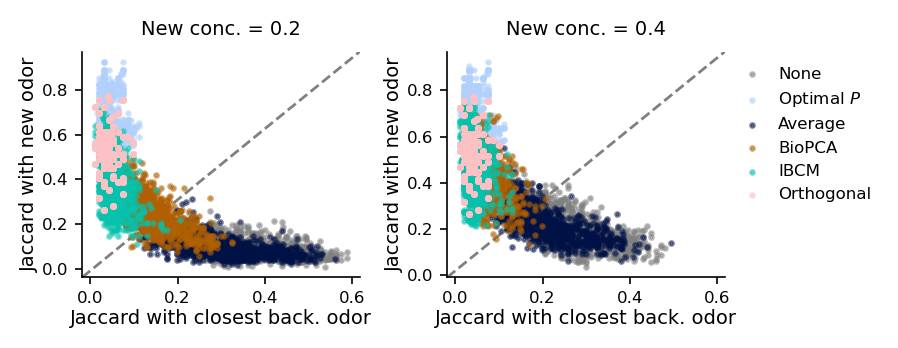

In [42]:
# Scatter plot of Jaccard similarity to new odor alone vs similarity to most similar background odor
jaccard_scores_with_back_max = {a:np.amax(jaccard_scores_with_back[a], axis=4) for a in jaccard_scores_with_back}

# Plot model histogram results
# One plot per new odor concentration
fig, axes = plt.subplots(1, n_new_concs, sharex=True)
fig.set_size_inches(plt.rcParams["figure.figsize"][0]*2.0, 
                    1.0*plt.rcParams["figure.figsize"][1])
axes = axes.flatten()
models = ["none", "optimal", "avgsub", "biopca", "ibcm", "orthogonal"]
for m in models:  # Plot IBCM last
    all_jacs = np.median(jaccard_scores[m], axis=(1,))  # Median time point, all back samples there
    all_jacs_back = np.median(jaccard_scores_with_back_max[m], axis=(1,))
    for i in range(n_new_concs):
        axes[i].scatter(all_jacs_back[:, i].flatten(), all_jacs[:, i].flatten(), 
            s=2.0, color=model_colors.get(m), alpha=0.5, label=model_nice_names[m])
# Labeling the graphs, etc.
for i in range(n_new_concs):
    ax = axes[i]
    ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", color="grey", lw=1.0, zorder=0)
    axes[i].set_title("New conc. = {:.1f}".format(new_test_concs[i]))
    axes[i].set_xlabel("Jaccard with closest back. odor")
    axes[i].set_ylabel("Jaccard with new odor")
axes[1].legend(loc="upper left", bbox_to_anchor=(1.0, 1.0), frameon=False)
fig.tight_layout()

#fig.savefig(os.path.join("figures", "detection", "compare_models_onerun_jaccards_with_back_ReLU.pdf"), 
#            transparent=True, bbox_inches="tight")

plt.show()
plt.close()